# Exploratory Data Analysis and Pre-processing

This notebook loads a subject's data from the WESAD dataset and visualizes physiological signals from both chest (RespiBAN) and wrist (Empatica E4) devices.

In [ ]:
# Importing Dependencies

import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import butter, filtfilt



# Disable UserWarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Pre-processing for Single Subject

In [2]:
# Path to the .pkl file
file_path = '/Users/sarvesh/Desktop/stress-detection-wesad/data/raw/S2/S2.pkl'  # Change this to the path where your .pkl file is located

# Load the pickle file
with open(file_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Display keys
print('Keys in the loaded data:', data.keys())

Keys in the loaded data: dict_keys(['signal', 'label', 'subject'])


In [3]:
# Extract signals and labels
chest_signals = data['signal']['chest']
wrist_signals = data['signal']['wrist']
labels = data['label']

print(data['signal']['chest'].keys())
print(data['signal']['wrist'].keys())

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [4]:
# Extract ECG, EDA, RESP from chest
ecg = data['signal']['chest']['ECG']
eda = data['signal']['chest']['EDA']
resp = data['signal']['chest']['Resp']

# Extract BVP and EDA from wrist
bvp = data['signal']['wrist']['BVP']
wrist_eda = data['signal']['wrist']['EDA']

# Labels
labels = data['label']

# Print shapes
print('ECG shape:', ecg.shape)
print('Chest EDA shape:', eda.shape)
print('Respiration shape:', resp.shape)
print('Wrist BVP shape:', bvp.shape)
print('Wrist EDA shape:', wrist_eda.shape)
print('Labels shape:', labels.shape)


ECG shape: (4255300, 1)
Chest EDA shape: (4255300, 1)
Respiration shape: (4255300, 1)
Wrist BVP shape: (389056, 1)
Wrist EDA shape: (24316, 1)
Labels shape: (4255300,)


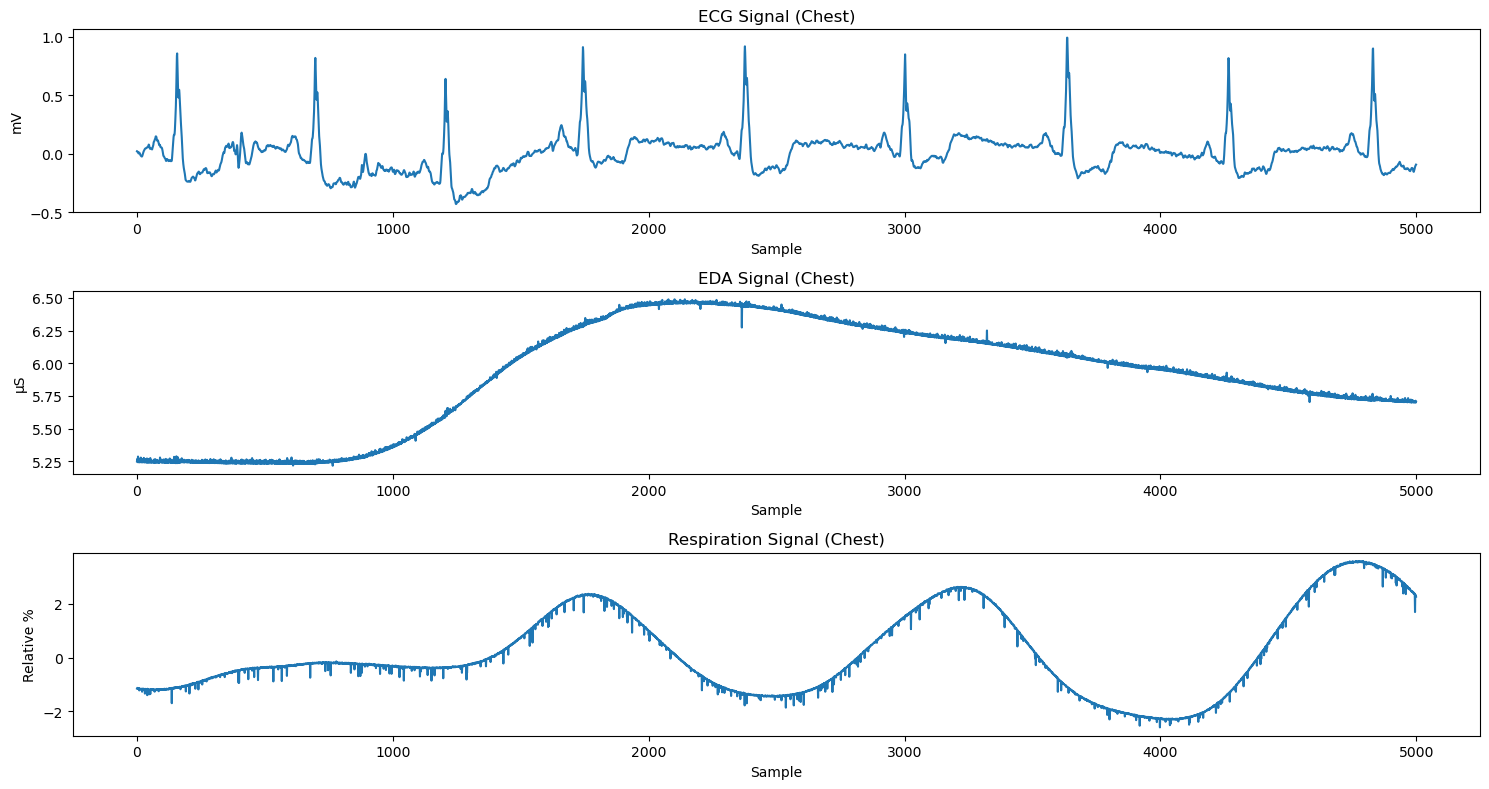

In [5]:
# Plot ECG, EDA, Respiration from chest

plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(ecg[:5000])
plt.title("ECG Signal (Chest)")
plt.xlabel("Sample")
plt.ylabel("mV")

plt.subplot(3, 1, 2)
plt.plot(eda[:5000])
plt.title("EDA Signal (Chest)")
plt.xlabel("Sample")
plt.ylabel("μS")

plt.subplot(3, 1, 3)
plt.plot(resp[:5000])
plt.title("Respiration Signal (Chest)")
plt.xlabel("Sample")
plt.ylabel("Relative %")

plt.tight_layout()
plt.show()

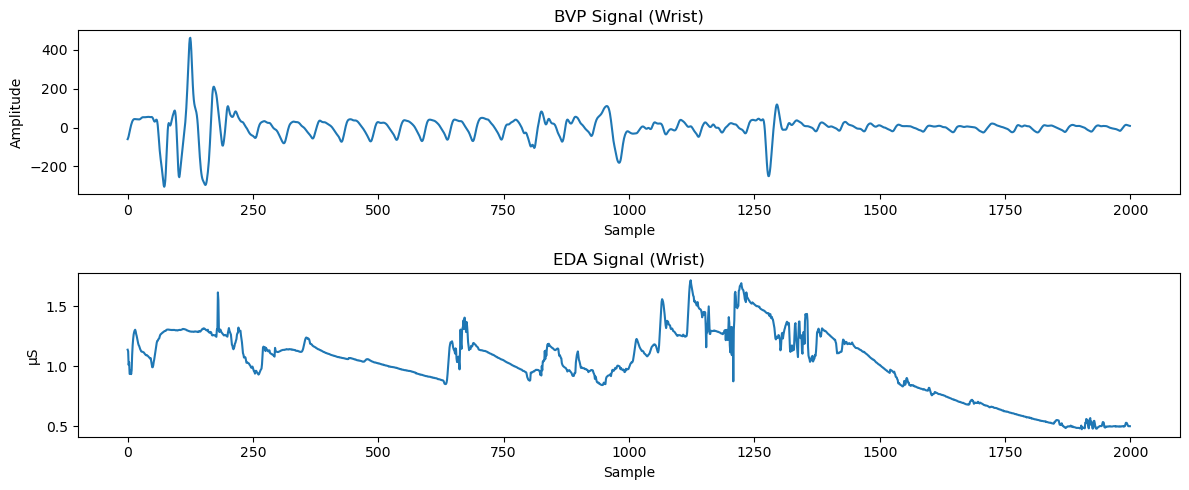

In [6]:


plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(bvp[:2000])
plt.title("BVP Signal (Wrist)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(wrist_eda[:2000])
plt.title("EDA Signal (Wrist)")
plt.xlabel("Sample")
plt.ylabel("μS")

plt.tight_layout()
plt.show()


In [7]:
ecg = np.array(ecg).flatten()
eda = np.array(eda).flatten()
resp = np.array(resp).flatten()


In [8]:
from scipy.signal import butter, filtfilt
import numpy as np

fs = 700  # Sampling frequency

# Filtering functions
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=700, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def lowpass_filter(signal, cutoff=1.0, fs=700, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def zscore_normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

In [9]:
print("ECG length:", len(ecg))
print("EDA length:", len(eda))
print("RESP length:", len(resp))


ECG length: 4255300
EDA length: 4255300
RESP length: 4255300


In [10]:
# Filtered signals
ecg_filtered = bandpass_filter(ecg)
eda_filtered = lowpass_filter(eda)
resp_filtered = lowpass_filter(resp)


# Normalized signals
ecg_norm = zscore_normalize(ecg_filtered)
eda_norm = zscore_normalize(eda_filtered)
resp_norm = zscore_normalize(resp_filtered)


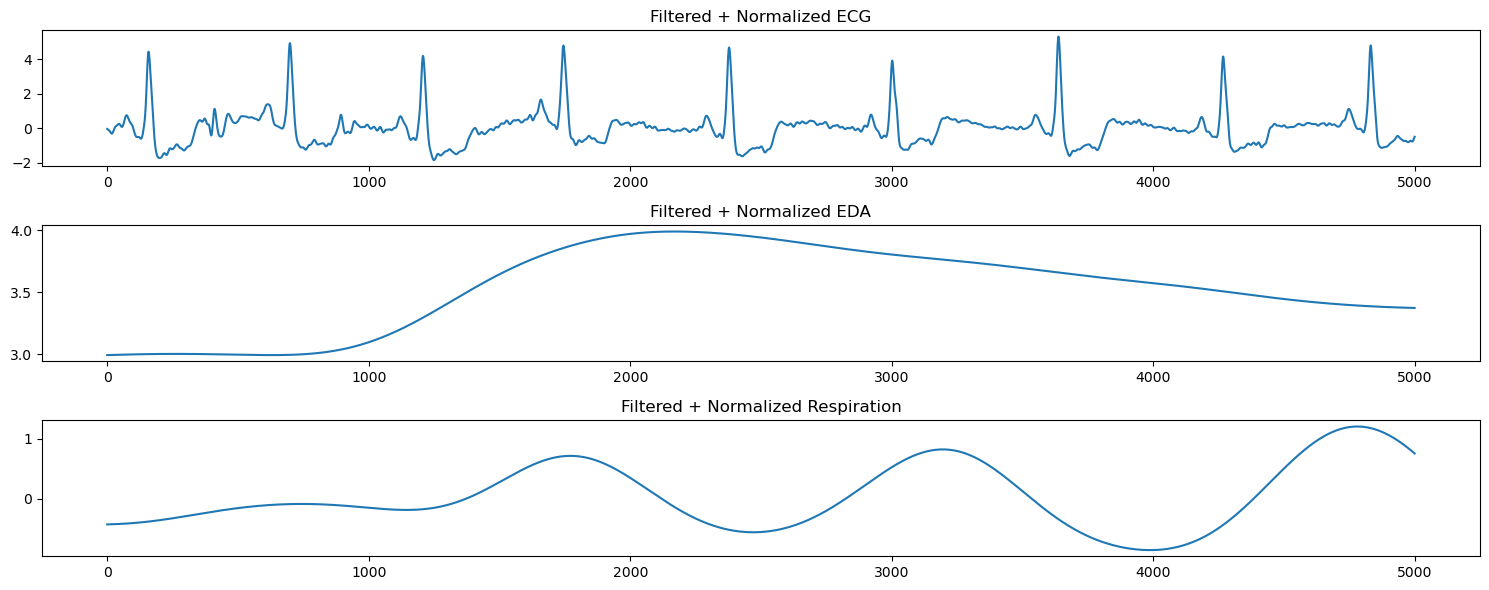

In [11]:
# Visualizing the Normalized Signals

plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
plt.plot(ecg_norm[:5000])
plt.title("Filtered + Normalized ECG")

plt.subplot(3, 1, 2)
plt.plot(eda_norm[:5000])
plt.title("Filtered + Normalized EDA")

plt.subplot(3, 1, 3)
plt.plot(resp_norm[:5000])
plt.title("Filtered + Normalized Respiration")

plt.tight_layout()
plt.show()


### Segmenting Signal into Fixed-Length Windows

In [12]:
fs = 700  # Sampling frequency in Hz
window_sec = 60
window_size = fs * window_sec  # number of samples per window
stride = int(window_size * 0.5)  # 50% overlap


def segment_signal(signal, window_size, stride):
    return np.array([
        signal[i:i + window_size]
        for i in range(0, len(signal) - window_size + 1, stride)
    ])


In [13]:
ecg_segments = segment_signal(ecg_norm, window_size, stride)
eda_segments = segment_signal(eda_norm, window_size, stride)
resp_segments = segment_signal(resp_norm, window_size, stride)

print("ECG segments:", ecg_segments.shape)
print("EDA segments:", eda_segments.shape)
print("Resp segments:", resp_segments.shape)

ECG segments: (201, 42000)
EDA segments: (201, 42000)
Resp segments: (201, 42000)


In [14]:
X = np.stack([ecg_segments, eda_segments, resp_segments], axis=-1)
print("Segmented data shape:", X.shape)  # should be (num_segments, window_size, 3)


Segmented data shape: (201, 42000, 3)


### Assigning Labels to Each Segment

In [15]:
labels = data['label'].flatten()  # make sure it's 1D

def segment_labels(labels, window_size, stride):
    return np.array([
        np.bincount(labels[i:i + window_size]).argmax()
        for i in range(0, len(labels) - window_size + 1, stride)
    ])

y = segment_labels(labels, window_size, stride)


In [16]:
print("Labels shape:", y.shape)
print("Label values:", np.unique(y, return_counts=True))


Labels shape: (201,)
Label values: (array([0, 1, 2, 3, 4, 6, 7]), array([101,  38,  21,  12,  25,   2,   2]))


In [18]:
np.save("/Users/sarvesh/Desktop/stress-detection-wesad/data/processed/S2_segments.npy", X)
np.save("/Users/sarvesh/Desktop/stress-detection-wesad/data/processed/S2_labels.npy", y)

print("Saved X and y to data/processed/")

Saved X and y to data/processed/


## 2. Pre-processing for All Subjects

In [19]:
# Config
fs = 700
window_sec = 60
window_size = fs * window_sec
stride = int(window_size * 0.5)

# Subject list (skip 1 and 12)
subjects = [f"S{i}" for i in range(3, 18) if i != 12]
raw_path = "/Users/sarvesh/Desktop/stress-detection-wesad/data/raw" 
out_path = "/Users/sarvesh/Desktop/stress-detection-wesad/data/processed"

os.makedirs(out_path, exist_ok=True)

for subj in subjects:
    try:
        print(f"\n🔄 Processing {subj}...")
        with open(f"{raw_path}/{subj}/{subj}.pkl", "rb") as f:
            data = pickle.load(f, encoding='latin1')

        chest = data["signal"]["chest"]
        labels = data["label"].flatten()

        ecg = zscore_normalize(bandpass_filter(np.ravel(chest["ECG"])))
        eda = zscore_normalize(lowpass_filter(np.ravel(chest["EDA"])))
        resp = zscore_normalize(lowpass_filter(np.ravel(chest["Resp"])))

        ecg_segments = segment_signal(ecg, window_size, stride)
        eda_segments = segment_signal(eda, window_size, stride)
        resp_segments = segment_signal(resp, window_size, stride)

        X = np.stack([ecg_segments, eda_segments, resp_segments], axis=-1)
        y = segment_labels(labels, window_size, stride)

        np.save(f"{out_path}/{subj}_segments.npy", X)
        np.save(f"{out_path}/{subj}_labels.npy", y)

        print(f"✅ Done: {X.shape[0]} segments saved.")
    except Exception as e:
        print(f"❌ Failed to process {subj}: {e}")




🔄 Processing S3...
✅ Done: 215 segments saved.

🔄 Processing S4...
✅ Done: 213 segments saved.

🔄 Processing S5...
✅ Done: 207 segments saved.

🔄 Processing S6...
✅ Done: 234 segments saved.

🔄 Processing S7...
✅ Done: 173 segments saved.

🔄 Processing S8...
✅ Done: 181 segments saved.

🔄 Processing S9...
✅ Done: 173 segments saved.

🔄 Processing S10...
✅ Done: 182 segments saved.

🔄 Processing S11...
✅ Done: 173 segments saved.

🔄 Processing S13...
✅ Done: 183 segments saved.

🔄 Processing S14...
✅ Done: 183 segments saved.

🔄 Processing S15...
✅ Done: 174 segments saved.

🔄 Processing S16...
✅ Done: 186 segments saved.

🔄 Processing S17...
✅ Done: 196 segments saved.


## 3. Inspect the Processed Signals

In [ ]:
def inspect_subject(subj_id):

    X = np.load(f"/Users/sarvesh/Desktop/stress-detection-wesad/data/processed/{subj_id}_segments.npy")
    y = np.load(f"/Users/sarvesh/Desktop/stress-detection-wesad/data/processed/{subj_id}_labels.npy")

    print(f"Subject '{subj_id}': \n")
    print(f"  Shape: {X.shape}")
    print(f"  Label distribution: {np.unique(y, return_counts=True)}")

    plt.figure(figsize=(15, 4))
    plt.subplot(3, 1, 1)
    plt.plot(X[0, :, 0])
    plt.title(f"{subj_id} – ECG")

    plt.subplot(3, 1, 2)
    plt.plot(X[0, :, 1])
    plt.title("EDA")

    plt.subplot(3, 1, 3)
    plt.plot(X[0, :, 2])
    plt.title("Respiration")

    plt.tight_layout()
    plt.show()


Inspecting Individual Subject

📦 S4:
  Shape: (213, 42000, 3)
  Label distribution: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([108,  39,  21,  12,  27,   2,   2,   2]))


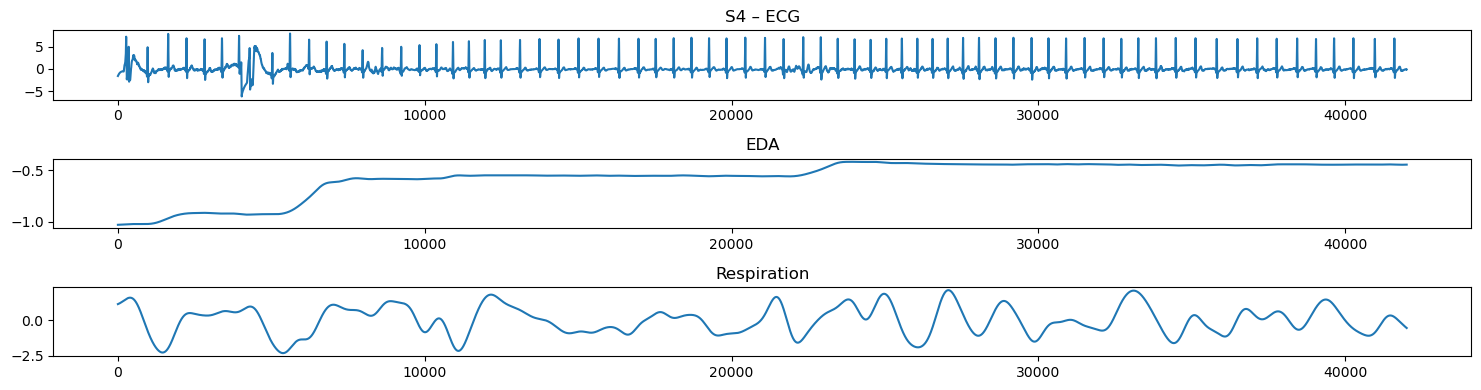

In [ ]:
inspect_subject("S4")